## **Connect and query a db with sqlite and explore it with tidymodels**

In [2]:
library(DBI)
library(RSQLite)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
mydb <- dbConnect(RSQLite::SQLite(), "")

In [4]:
ratings <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-25/ratings.csv')
details <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-25/details.csv')


Rows: 21831 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): name, url, thumbnail
dbl (7): num, id, year, rank, average, bayes_average, users_rated

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 21631 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): primary, description, boardgamecategory, boardgamemechanic, boardg...
dbl (13): num, id, yearpublished, minplayers, maxplayers, playingtime, minpl...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
mydb <- dbConnect(RSQLite::SQLite(), "")
dbWriteTable(mydb, "ratings", ratings)
dbWriteTable(mydb, "details", details)
dbListTables(mydb)

[1] "details" "ratings"

In [ ]:
dbGetQuery(mydb, 'SELECT * FROM ratings LIMIT 5')

In [ ]:
dbGetQuery(mydb, 'SELECT * FROM details LIMIT 5')

In [6]:
colnames(details)

[1] "num"                     "id"                     
 [3] "primary"                 "description"            
 [5] "yearpublished"           "minplayers"             
 [7] "maxplayers"              "playingtime"            
 [9] "minplaytime"             "maxplaytime"            
[11] "minage"                  "boardgamecategory"      
[13] "boardgamemechanic"       "boardgamefamily"        
[15] "boardgameexpansion"      "boardgameimplementation"
[17] "boardgamedesigner"       "boardgameartist"        
[19] "boardgamepublisher"      "owned"                  
[21] "trading"                 "wanting"                
[23] "wishing"

In [35]:
res <- dbGetQuery(mydb, 'SELECT details.id, name, description, yearpublished, boardgamecategory, users_rated, rank, average, owned FROM details INNER JOIN ratings On details.id = ratings.id')
res %>%
  slice_head(n=5)

id,name,description,yearpublished,boardgamecategory,users_rated,rank,average,owned
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
30549,Pandemic,"In Pandemic, several virulent diseases have broken out simultaneously all over the world! The players are disease-fighting specialists whose mission is to treat disease hotspots while researching cures for each of four plagues before they get out of hand.&#10;&#10;The game board depicts several major population centers on Earth. On each turn, a player can use up to four actions to travel between cities, treat infected populaces, discover a cure, or build a research station. A deck of cards provides the players with these abilities, but sprinkled throughout this deck are Epidemic! cards that accelerate and intensify the diseases' activity. A second, separate deck of cards controls the &quot;normal&quot; spread of the infections.&#10;&#10;Taking a unique role within the team, players must plan their strategy to mesh with their specialists' strengths in order to conquer the diseases. For example, the Operations Expert can build research stations which are needed to find cures for the diseases and which allow for greater mobility between cities; the Scientist needs only four cards of a particular disease to cure it instead of the normal five&mdash;but the diseases are spreading quickly and time is running out. If one or more diseases spreads beyond recovery or if too much time elapses, the players all lose. If they cure the four diseases, they all win!&#10;&#10;The 2013 edition of Pandemic includes two new characters&mdash;the Contingency Planner and the Quarantine Specialist&mdash;not available in earlier editions of the game.&#10;&#10;Pandemic is the first game in the Pandemic series.&#10;&#10;",2008,['Medical'],108975,106,7.59,168364
822,Carcassonne,"Carcassonne is a tile-placement game in which the players draw and place a tile with a piece of southern French landscape on it. The tile might feature a city, a road, a cloister, grassland or some combination thereof, and it must be placed adjacent to tiles that have already been played, in such a way that cities are connected to cities, roads to roads, etcetera. Having placed a tile, the player can then decide to place one of their meeples on one of the areas on it: on the city as a knight, on the road as a robber, on a cloister as a monk, or on the grass as a farmer. When that area is complete, that meeple scores points for its owner.&#10;&#10;During a game of Carcassonne, players are faced with decisions like: &quot;Is it really worth putting my last meeple there?&quot; or &quot;Should I use this tile to expand my city, or should I place it near my opponent instead, giving him a hard time to complete their project and score points?&quot; Since players place only one tile and have the option to place one meeple on it, turns proceed quickly even if it is a game full of options and possibilities.&#10;&#10;First game in the Carcassonne series.&#10;&#10;",2000,"['City Building', 'Medieval', 'Territory Building']",108738,190,7.42,161299
13,Catan,"In CATAN (formerly The Settlers of Catan), players try to be the dominant force on the island of Catan by building settlements, cities, and roads. On each turn dice are rolled to determine what resources the island produces. Players build by spending resources (sheep, wheat, wood, brick and ore) that are depicted by these resource cards; each land type, with the exception of the unproductive desert, produces a specific resource: hills produce brick, forests produce wood, mountains produce ore, fields produce wheat, and pastures produce sheep.&#10;&#10;Setup includes randomly placing large hexagonal tiles (each showing a resource or the desert) in a honeycomb shape and surrounding them with water tiles, some of which contain ports of exchange. Number disks, which will correspond to die rolls (two 6-sided dice are used), are placed on each resource tile. Each player is given two settlements (t

In [8]:
res <- res %>%
mutate(yearpublished=as.numeric(yearpublished)) %>%
filter(!is.na(yearpublished)) %>% 
filter(yearpublished <= 2016) %>%
filter(yearpublished >= 1960) %>%
filter(users_rated >= 5)

res %>% glimpse()

Rows: 15,582
Columns: 9
$ id                <dbl> 30549, 822, 13, 68448, 36218, 9209, 178900, 167791, …
$ name              <chr> "Pandemic", "Carcassonne", "Catan", "7 Wonders", "Do…
$ description       <chr> "In Pandemic, several virulent diseases have broken …
$ yearpublished     <dbl> 2008, 2000, 1995, 2010, 2008, 2004, 2015, 2016, 2015…
$ boardgamecategory <chr> "['Medical']", "['City Building', 'Medieval', 'Terri…
$ users_rated       <dbl> 108975, 108738, 108024, 89982, 81561, 76171, 74419, …
$ rank              <dbl> 106, 190, 429, 73, 104, 192, 101, 4, 16, 36, 31, 183…
$ average           <dbl> 7.59, 7.42, 7.14, 7.74, 7.61, 7.41, 7.60, 8.42, 8.11…
$ playingtime       <dbl> 45, 45, 120, 30, 30, 60, 15, 120, 30, 150, 150, 30, …


In [9]:
# summarize by year
boardgames_by_year <- res %>%
  group_by(yearpublished) %>%
  summarise(count = n())

boardgames_by_year  

yearpublished,count
<dbl>,<int>
1960,23
1961,11
1962,18
1963,17
1964,17
1965,26
1966,10
1967,20
1968,25


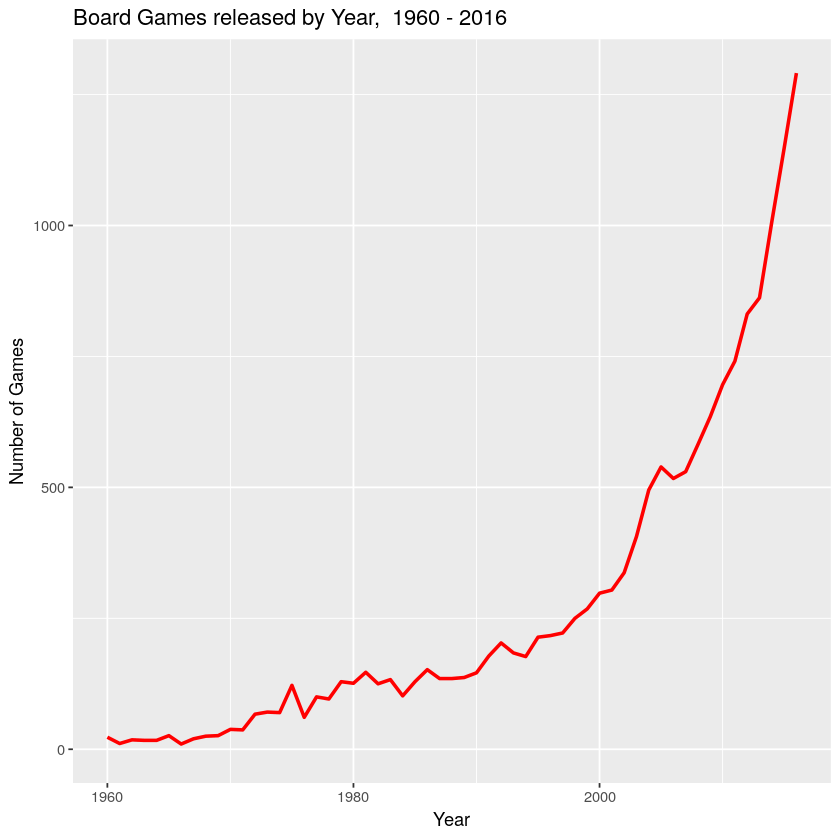

In [10]:
ggplot(boardgames_by_year,aes(yearpublished,count)) +
  geom_line(col="red", lwd=1) +
  ggtitle(paste('Board Games released by Year, ', min(boardgames_by_year$yearpublished),'-', max(boardgames_by_year$yearpublished))) +
  xlab('Year') +
  ylab("Number of Games") +
  ylim(c(0,max(boardgames_by_year$count)))

Warning message:
“Use of `res$average` is discouraged. Use `average` instead.”
Warning message:
“Use of `res$average` is discouraged. Use `average` instead.”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


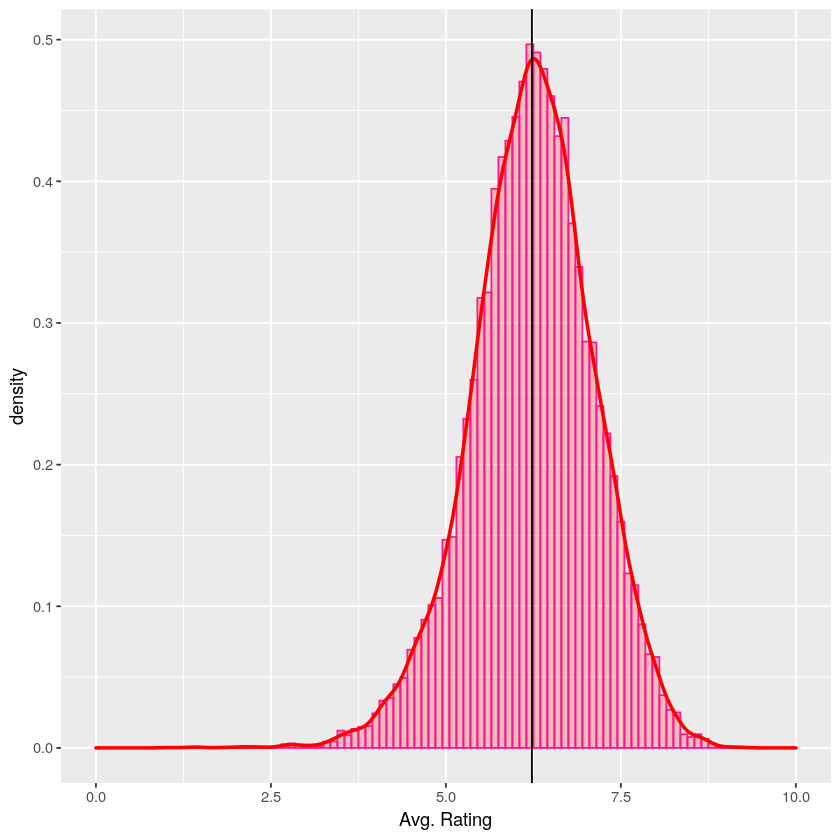

In [11]:
# Rating Distribution
ggplot(res, aes(x = res$average)) +
  geom_histogram(aes(y = ..density..), binwidth = .1, fill="red", alpha=.2, col="deeppink") + geom_density(col="red", lwd=1) +
  xlim(0,10) +
  xlab('Avg. Rating') +
  geom_vline(xintercept=mean(res$average, na.rm=TRUE), color="black")

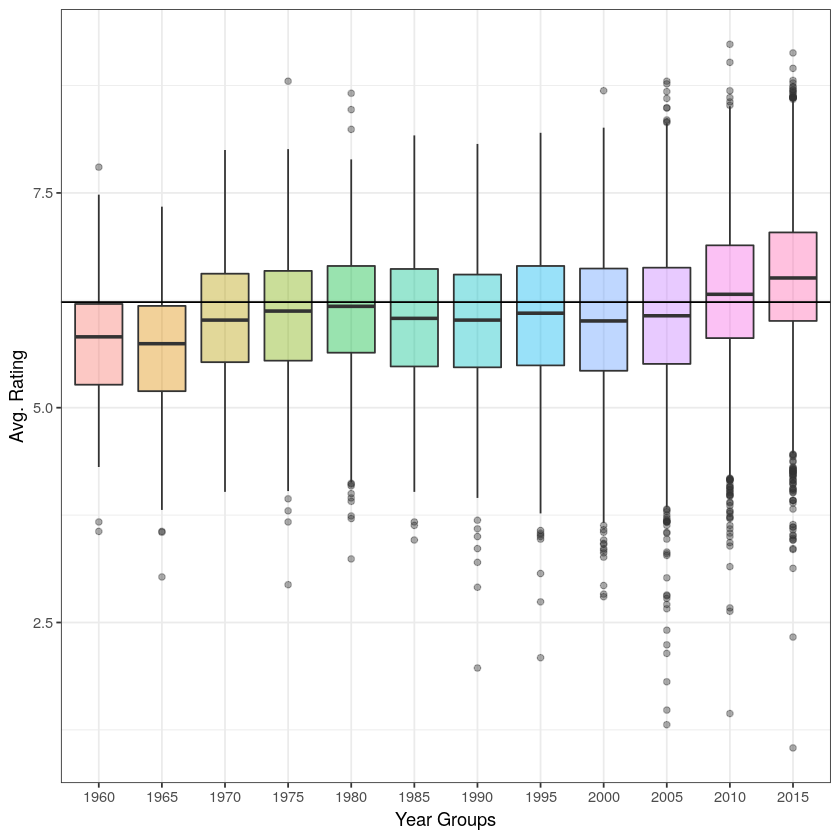

In [12]:
# Splitting by year class
ggplot(res %>%
         mutate(year_group=as.factor(plyr::round_any(as.numeric(yearpublished), 5))) %>%
         filter(as.numeric(yearpublished) >=1960 & as.numeric(yearpublished) <= 2016)
       , aes(year_group, average, fill=year_group)) +
  geom_boxplot(alpha=.4) +
  theme_bw() +
  ylab("Avg. Rating") + xlab("Year Groups") +
  geom_hline(yintercept=mean(res$average, na.rm=TRUE), color="black") +
  theme(legend.position="none")

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


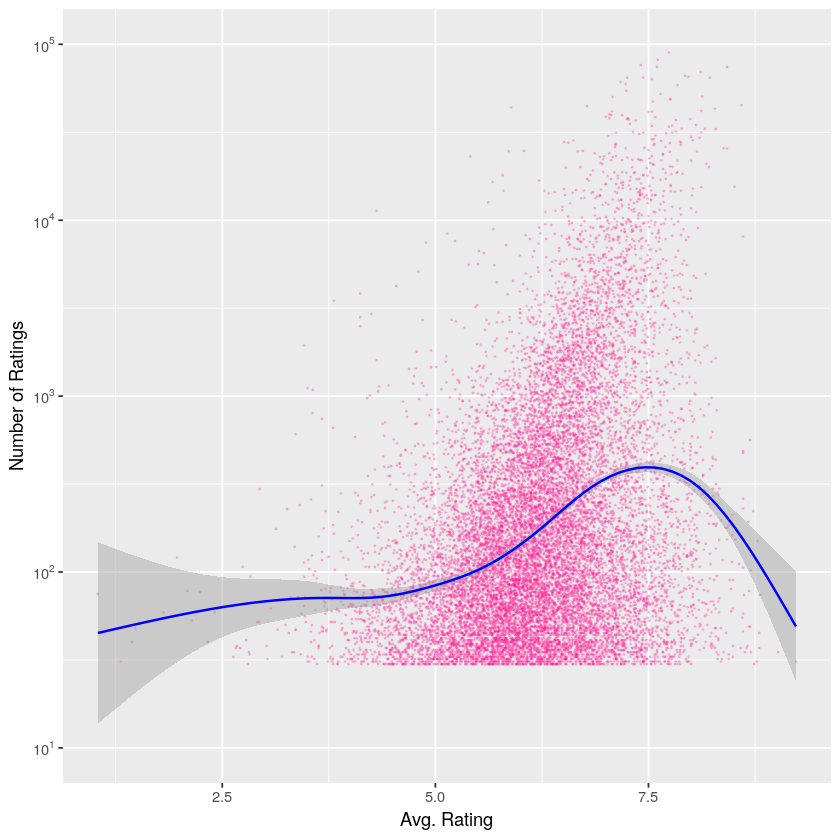

In [31]:
  ggplot(res
         %>% filter(users_rated >= 10)
         , aes(average, users_rated)) +
    geom_point(alpha=.2, lwd=.2, col="deeppink") +
    geom_smooth(col="blue", lwd=.7) +
    ylab("Number of Ratings") + scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                                              labels = trans_format("log10", math_format(10^.x)),
                                              limits = c(10,10^5)) +
    xlab("Avg. Rating")

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 49 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 48 rows containing missing values (geom_point).”


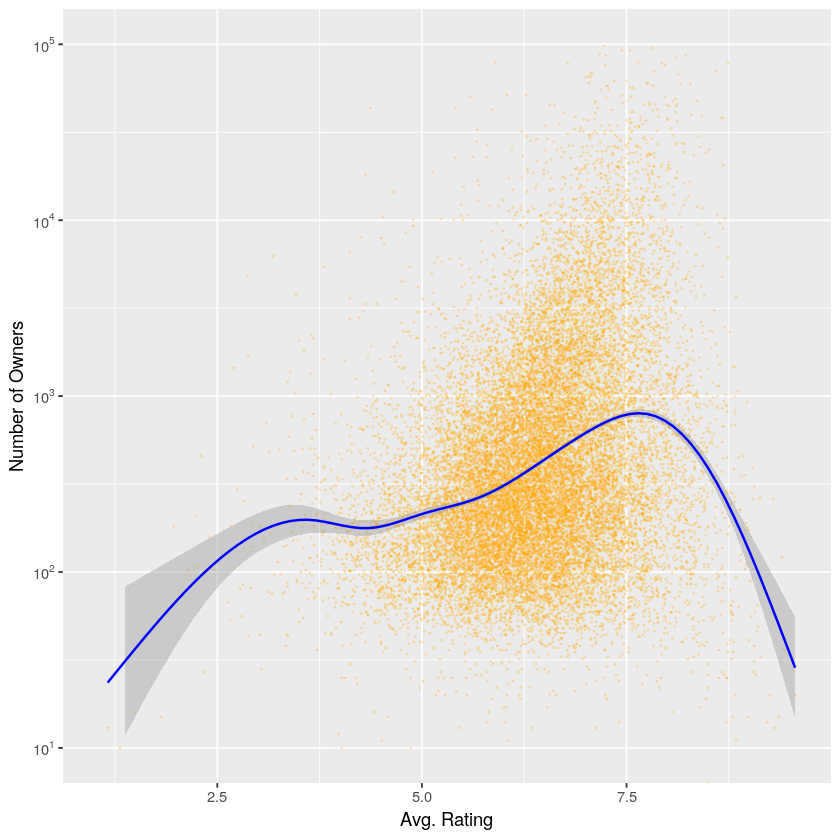

In [36]:
  ggplot(res
         %>% filter(users_rated >= 10)
         , aes(average, owned)) +
    geom_point(alpha=.2, lwd=.2, col="orange") +
    geom_smooth(col="blue", lwd=.7) +
    ylab("Number of Owners") + scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                                             labels = trans_format("log10", math_format(10^.x)),
                                             limits = c(10,10^5)) +
    xlab("Avg. Rating")